In [1]:
#IMPORTS
import os,urllib.request


# PROVIDE YOUR DOWNLOAD DIRECTORY HERE
datapath = '../../Data/MNISTData/'  

# CREATING DOWNLOAD DIRECTORY
if not os.path.exists(datapath):
    os.makedirs(datapath)

# URLS TO DOWNLOAD FROM
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

for url in urls:
    filename = url.split('/')[-1]   # GET FILENAME
    
    if os.path.exists(datapath+filename):
        print(filename, ' already exists')  # CHECK IF FILE EXISTS
    else:
        print('Downloading ',filename)
        urllib.request.urlretrieve (url, datapath+filename) # DOWNLOAD FILE
     
print('All files are available')

All files are available


In [2]:
import os,gzip,shutil

# PROVIDE YOUR DOWNLOAD DIRECTORY HERE
datapath = '../../Data/MNISTData/'  

# LISTING ALL ARCHIVES IN THE DIRECTORY
files = os.listdir(datapath)
for file in files:
    if file.endswith('gz'):
        print('Extracting ',file)
        with gzip.open(datapath+file, 'rb') as f_in:
            with open(datapath+file.split('.')[0], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
print('Extraction Complete')

# OPTIONAL REMOVE THE ARCHIVES
for file in files:
    print('Removing ',file)
    os.remove(datapath+file)
print ('All archives removed')

Extracting  t10k-images-idx3-ubyte.gz
Extracting  train-images-idx3-ubyte.gz
Extracting  train-labels-idx1-ubyte.gz
Extracting  t10k-labels-idx1-ubyte.gz
Extraction Complete
Removing  t10k-images-idx3-ubyte.gz
Removing  train-images-idx3-ubyte.gz
Removing  train-labels-idx1-ubyte.gz
Removing  t10k-labels-idx1-ubyte.gz
All archives removed


In [1]:
import os,codecs,numpy

# PROVIDE YOUR DIRECTORY WITH THE EXTRACTED FILES HERE
datapath = '../../Data/MNISTData/'

files = os.listdir(datapath)

def get_int(b):   # CONVERTS 4 BYTES TO A INT
    return int(codecs.encode(b, 'hex'), 16)

data_dict = {}
for file in files:
    if file.endswith('ubyte'):  # FOR ALL 'ubyte' FILES
        print('Reading ',file)
        with open (datapath+file,'rb') as f:
            data = f.read()
            type = get_int(data[:4])   # 0-3: THE MAGIC NUMBER TO WHETHER IMAGE OR LABEL
            length = get_int(data[4:8])  # 4-7: LENGTH OF THE ARRAY  (DIMENSION 0)
            if (type == 2051):
                category = 'images'
                num_rows = get_int(data[8:12])  # NUMBER OF ROWS  (DIMENSION 1)
                num_cols = get_int(data[12:16])  # NUMBER OF COLUMNS  (DIMENSION 2)
                parsed = numpy.frombuffer(data,dtype = numpy.uint8, offset = 16)  # READ THE PIXEL VALUES AS INTEGERS
                parsed = parsed.reshape(length,num_rows,num_cols)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES x HEIGHT x WIDTH]           
            elif(type == 2049):
                category = 'labels'
                parsed = numpy.frombuffer(data, dtype=numpy.uint8, offset=8) # READ THE LABEL VALUES AS INTEGERS
                parsed = parsed.reshape(length)  # RESHAPE THE ARRAY AS [NO_OF_SAMPLES]                           
            if (length==10000):
                set = 'test'
            elif (length==60000):
                set = 'train'
            data_dict[set+'_'+category] = parsed  # SAVE THE NUMPY ARRAY TO A CORRESPONDING KEY

Reading  t10k-images-idx3-ubyte
Reading  t10k-labels-idx1-ubyte
Reading  train-images-idx3-ubyte
Reading  train-labels-idx1-ubyte


In [7]:
train_images = data_dict['train_images']
print(train_images.shape)
train_labels = data_dict['train_labels']
print(train_labels.shape)
test_images = data_dict['test_images']
print(test_images.shape)
test_labels = data_dict['test_labels']
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [21]:
print(train_labels[0])

5


In [61]:
import numpy as np
import array

np.seterr(divide='ignore', invalid='ignore')

picture_size = 784
hidden_layer_size = 32
output_layer_size = 10
batch_size = 100

# Сургах зурагны хэмжээ
train_image_size = 60000
# Divisor нь 0-1 н хооронд болгохын тулд үржиж байгаа тоо.
divisor = 1/255
print("Starting ...")
# Энд train_images гэсэн энгийн array - г numpy-ын array болгож байна. 
np.array(train_images)
np.array(train_labels)
np.array(test_images)
np.array(test_labels)
# Харин энд зураг тус бүрийг 0-1 хооронд байхаар pixel бүрээр үржиж байна гэсэн үг.
c_train_image = train_images*(divisor)
c_test_image = test_images*(divisor)

print("train image shape:")
print(c_train_image.shape);
print("test image shape:")
print(c_test_image.shape);

# За энд hidden layer-н W болон B уудыг random - р үүсгэж байна.
layer1_weight = np.random.randn(picture_size,hidden_layer_size)*0.01
print("Layer1 shape:")
print(layer1_weight.shape)
print("Layer1 weight:")
print(layer1_weight)
layer1_bias = np.random.randn(hidden_layer_size)
print("Layer1 bias shape:")
print(layer1_bias.shape)
print("Layer1 bias:")
print(layer1_bias)

# За энд гаралтын layer -н W болон B уудыг random - р үүсгэж байна.
layer2_weight = np.random.randn(hidden_layer_size,output_layer_size)*0.01
print("Layer2 weight shape:")
print(layer2_weight.shape)
print("Layer2 weight:")
print(layer2_weight)
layer2_bias = np.random.randn(output_layer_size)
print("Layer2 bias shape:")
print(layer2_bias.shape)
print("Layer2 bias:")
print(layer2_bias)

# Энд (60000,28,28) хэмжээтэй зураг аа (60000,784) хэмжээтэй вектор болгож байна.
cv_train_image = np.reshape(c_train_image,(60000,784))
print("Сургах өгөгдлөө вектор болгох нь:")
print(cv_train_image.shape)
cv_test_image = np.reshape(c_test_image,(10000,784))
print("Турших өгөгдөл өө вектор болгох нь:")
print(cv_test_image.shape)

# Энд batch_size сонгож авах хэсгийг хийж байна.
#cv_train_image

print("train_image size:")
print(cv_train_image.shape[0])
print("******************************************************************************************************************")
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

# def softmax(inputs):
#     return np.exp(inputs) / float(sum(np.exp(inputs)))

def relu(x):
    return np.maximum(0,x)


i = 0
batch_size = 100

for index in range(0,6000,batch_size):
    batch=cv_train_image[index:min(index+batch_size,cv_train_image.shape[0]),:]
    for i in range(batch_size):
        layer1 = np.add(batch@layer1_weight,layer1_bias)
        layer1 = relu(layer1)
        layer2 = np.add(layer1@layer2_weight,layer2_bias)
        layer2 = softmax(layer2)
        grad = softmax(layer2)
        layer2 = softmax(layer2)
        loss = -np.log(layer2[range(batch_size),train_labels[i]])
        print("loss:",loss)
        loss_sum = np.sum(loss)/batch_size
        print("Loss_sum:",loss_sum)
        grad[range(batch_size),train_labels]

# log_likelihood = -np.log(layer1[range(layer1_size),true_label])
# loss = np.sum(log_likelihood)/layer1_size
# print("Loss:")
# print(loss)
# print("Softmax avsni daraa:")
# print(softmax(layer1))


# print("Cross entropy is :")
# print(cross_entropy(layer1,train_labels))

# print("Delta cross entropy:")
# print(delta_cross_entropy(layer1,train_labels))

# layer2 = np.add(layer1@layer2_weight,layer2_bias)
# print("Layer2 shape is:")
# print(layer2.shape)
# print("Layer2 is:")
# print(layer2)
# print("Softmax:")
# print(softmax(layer2))



# def training(w1,b1,w2,b2,image):
#     layer1 = image@w1+b1
#     layer2 = layer1@w2 + b2
#     layer2 = ReLU(layer2)
#     return softmax(layer2)

# training(layer1_weight,layer1_bias,layer1_weight,layer2_bias,one)

# Оролт=>w1,b1=>relu=>w2,b2=>softmax=>гаралт

# def cut_data(batch_size,cv_train_image):


Starting ...
train image shape:
(60000, 28, 28)
test image shape:
(10000, 28, 28)
Layer1 shape:
(784, 32)
Layer1 weight:
[[ 0.00700561  0.01457133  0.00611624 ... -0.00043699 -0.01413582
   0.00941446]
 [-0.00116733 -0.01297893 -0.00446566 ...  0.00393103 -0.0018988
  -0.00398811]
 [ 0.00722992 -0.00446425  0.00911617 ...  0.0008599  -0.00901204
  -0.00028093]
 ...
 [ 0.00486891  0.01041855 -0.02130162 ...  0.01143235 -0.0029017
   0.00602883]
 [-0.00684251  0.00583687  0.02005233 ...  0.00510158  0.00516081
  -0.00120531]
 [-0.00916377 -0.00776708 -0.00371561 ... -0.01872538  0.00196962
  -0.01159553]]
Layer1 bias shape:
(32,)
Layer1 bias:
[ 0.74701675  1.69568277  0.27073458  0.87930262 -0.34605261  1.70841628
  1.32335184 -0.03534337  0.598259   -1.06225106 -1.00810206 -0.27838215
 -0.5201713   0.0418472  -1.57079724  0.54907801  0.09338558  0.607091
 -0.05255035  1.29972664  0.62998146  0.34271081  0.48358198  0.01832229
 -0.10595982 -0.65562628  0.58799007  1.30547785  1.10159897 

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (100,) (60000,) 

In [59]:
war = np.random.randn(100,10)
print(war[0])
print(war[1])
print(war[2])
wer = np.random.randn(100)
print("za hevleeey")
print(war[range(10),1])
# layer2[range(batch_size),train_labels])

[ 1.75000627  0.80353831  1.80740112  2.40222556 -1.09723574  0.43517081
 -1.54370761 -1.03877696 -2.26556993  0.65098788]
[-1.05236219  1.60436353 -0.97792064  1.08177944  1.24188176 -0.29991032
  1.31645283  0.20183744  0.51819745 -1.11926745]
[ 0.75251745  0.9969366  -1.16570319 -1.11220254  0.70134774  1.96144526
 -1.75077151 -1.16931924 -0.23239081 -1.37983009]
za hevleeey
[ 0.80353831  1.60436353  0.9969366  -0.11075664 -1.17732511  0.56477349
  1.10544942  0.95976135  0.17576103 -0.72964908]


In [54]:
batch_size = 100

for index in range(0,cv_train_image.shape[0],batch_size):
    batch=cv_train_image[index:min(index+batch_size,cv_train_image.shape[0]),:]
    print(batch.shape)

# import numpy as np
# data=np.random.rand(550,10)
# batch_size=100

# for index in range(0,data.shape[0],batch_size):
#     batch=data[index:min(index+batch_size,data.shape[0]),:]
#     print(batch.shape)
    
# print(data[min(5,9),:])    
# for i in range(0,550,100):
#     batch = data[i:min(i+100,550),:]
#     print(batch.shape)

500
(100, 10)
(100, 10)
(100, 10)
(100, 10)
(100, 10)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':


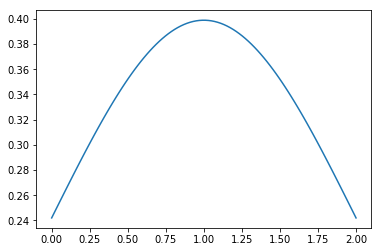

In [14]:


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 1
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 1*sigma, mu + 1*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

In [79]:
import numpy as np
ta = [58.43540903, 53.02501388, 57.71778442, 58.92268745, 56.44606285, 52.66033093,
 53.63167502, 58.72545242, 57.41629934, 52.45535283, 64.04863599, 55.95392181,
 55.36780029, 54.13148496, 51.61374528, 53.93820959]
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference
print(ta)
print("Softmax ashiglasni daraa:")
print(softmax(ta))
for i in range(0,16):
    ta[i] = ta[i] * 0.1
print("************************************************************************************")
print(ta)
print("Softmax ashiglasni daraa:")
print(softmax(ta))

[58.43540903, 53.02501388, 57.71778442, 58.92268745, 56.44606285, 52.66033093, 53.63167502, 58.72545242, 57.41629934, 52.45535283, 64.04863599, 55.95392181, 55.36780029, 54.13148496, 51.61374528, 53.93820959]
Softmax ashiglasni daraa:
[3.58228723e-03 1.60123711e-05 1.74783325e-03 5.83153296e-03
 4.90002546e-04 1.11192592e-05 2.93714395e-05 4.78767486e-03
 1.29290522e-03 9.05847304e-06 9.81643736e-01 2.99546465e-04
 1.66692038e-04 4.84161143e-05 3.90435664e-06 3.99072227e-05]
************************************************************************************
[5.843540903000001, 5.3025013880000005, 5.7717784420000005, 5.892268745, 5.644606285, 5.266033093000001, 5.3631675020000005, 5.872545242000001, 5.7416299340000005, 5.245535283000001, 6.404863599, 5.595392181, 5.536780029, 5.413148496000001, 5.1613745280000005, 5.393820959]
Softmax ashiglasni daraa:
[0.07629297 0.0444134  0.07100983 0.08010262 0.06252998 0.0428229
 0.0471912  0.0785382  0.06890094 0.04195406 0.13374078 0.05952712
 0

In [30]:
import pickle

datapath = '../../Data/MNISTData/'

# DUMPING THE DICTIONARY INTO A PICKLE 
with open(datapath+'MNISTData.pkl', 'wb') as fp :
    pickle.dump(data_dict, fp)

# LOADING THE DICTIONARY FROM A PICKLE
with open(datapath+'MNISTData.pkl', 'rb') as fp :
    new_dict = pickle.load(fp)
